<a href="https://colab.research.google.com/github/xujingwenuoft/PROGRESS-MODEL/blob/main/PROGRESS_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly

In [46]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#Read data from Excel
datafile = '/content/drive/MyDrive/Colab Notebooks/SR1 Input_Output_Feb20_20250313.xlsx'
data = pd.read_excel(datafile, sheet_name="Raw Scores - Cohort specific") # DataFrame object

# print(data.info())
print(data.columns)

Index(['Cognitive test', 'Author', 'Score', 'Cohort', 'Severity',
       'Baseline (mean)', 'Baseline (SD)', 'Baseline (other reporting)',
       'Last FU (mean)', 'Last FU (SD)', 'Last FU (other reporting)', 'n',
       'Country of recruitment', 'Age, mean ', 'Age, standard deviation',
       'Sex/gender, male/men (proportion)', 'Race, White (proportion)',
       'Race, Black (proportion)', 'Race, Hispanic (proportion)',
       'Race, Other (proportion)', 'Education, mean years',
       'Education, standard deviation ',
       'Education, <high school (proportion)',
       'Education, high school (proportion)',
       'Education, some college (proportion)',
       'Education, college (proportion)', 'Education, <12 years (proportion)',
       'Education, 12 years (proportion)', 'Education, >12 years (proportion)',
       'Education,  ≥ 12 years (proportion)',
       'Occupation, employed at time of injury (working for pay; full or part-time) (proportion)',
       'Occupation, not emplo

In [47]:
data.drop(columns=['Author', 'Score', 'Cohort',
                   'Test min value','test max value','Output'], inplace=True)
print(data.columns)

Index(['Cognitive test', 'Severity', 'Baseline (mean)', 'Baseline (SD)',
       'Baseline (other reporting)', 'Last FU (mean)', 'Last FU (SD)',
       'Last FU (other reporting)', 'n', 'Country of recruitment',
       'Age, mean ', 'Age, standard deviation',
       'Sex/gender, male/men (proportion)', 'Race, White (proportion)',
       'Race, Black (proportion)', 'Race, Hispanic (proportion)',
       'Race, Other (proportion)', 'Education, mean years',
       'Education, standard deviation ',
       'Education, <high school (proportion)',
       'Education, high school (proportion)',
       'Education, some college (proportion)',
       'Education, college (proportion)', 'Education, <12 years (proportion)',
       'Education, 12 years (proportion)', 'Education, >12 years (proportion)',
       'Education,  ≥ 12 years (proportion)',
       'Occupation, employed at time of injury (working for pay; full or part-time) (proportion)',
       'Occupation, not employed at time of injury (retire

In [57]:
# Process the assessment score SD missing value(with range, then without range)
# print(data['BL SD'][211])
data.loc[209, 'BL SD'] = 21.48
data.loc[210, 'BL SD'] = 20
data.loc[214, 'BL SD'] = 2.59

data.loc[209, 'Last FU SD'] = 14.44
data.loc[210, 'Last FU SD'] = 25.93
data.loc[214, 'Last FU SD'] = 18.52

# print(data['BL SD'][108])

# Fill missing 'BL SD' with group median, then overall median
data['BL SD'] = data['BL SD'].fillna(data.groupby('Cognitive test')['BL SD'].transform('median'))
data['BL SD'] = data['BL SD'].fillna(data['BL SD'].median()).astype(float)
# print(data['BL SD'][108])

# Fill missing 'Last FU SD' with group median, then overall median
data['Last FU SD'] = data['Last FU SD'].fillna(data.groupby('Cognitive test')['Last FU SD'].transform('median'))
data['Last FU SD'] = data['Last FU SD'].fillna(data['Last FU SD'].median()).astype(float)
# print(data['Last FU SD'][108])

In [49]:
print(data['Baseline (mean)'][0])
# uniform time(d/hrs/yrs/yr/wks/wk) to days
def filter_BLmean(x):
  match1 = re.search(r'(\d+\.\d+|\d+)\s+mos', str(x))
  match2 = re.match(r'(\d+\.\d+|\d+)\s+hrs', str(x))
  match3 = re.match(r'(\d+\.\d+|\d+)\s+(d|d+\s+p/i)', str(x))
  match4 = re.search(r'(\d+\.\d+|\d+)\s+(yr|yrs +\s+p/i)', str(x))
  match6 = re.match(r'(\d+\.\d+|\d+)\s+wks', str(x))
  match7 = re.match(r'(\d+\.\d+|\d+)\s+wk', str(x))
  match8 = re.match(r'immediately p/i', str(x))
  match9 = re.match(r'within 48 h', str(x))
  match10 = re.search(r'range:', str(x))
  match11 = re.match(r'within 2 wks', str(x))
  match12 = re.match(r'1-7 days p/i', str(x))
  if match1 is not None:
    return float(match1.group(1))*30
  elif match2 is not None:
    return float(match2.group(1))/24
  elif match3 is not None:
    return float(match3.group(1))
  elif match4 is not None:
    return float(match4.group(1))*365
  elif match6 is not None:
    return float(match6.group(1))*7
  elif match7 is not None:
    return float(match7.group(1))*7
  elif match8 is not None:
    return float(0.5)
  elif match9 is not None:
    return float(2)
  elif match10 is not None:
    return float(0.5)
  elif match11 is not None:
    return float(7)
  elif match12 is not None:
    return float(3.5)
  else:
    return x
# Apply column Baseline (other reporting) to Baseline (mean) if mean is nan
data['Baseline (mean)'].fillna(data['Baseline (other reporting)'], inplace=True)
data['BaselineTime(days)'] = data['Baseline (mean)'].apply(filter_BLmean)
print(data['BaselineTime(days)'].info)
# BLtimemean = pd.to_numeric(data['BaselineTime(days)'], errors='coerce').mean() # 175 days
# print(BLtimemean)
# String value: [0]within 2 wks, [78]1-7 days p/i, [10] range: 0-23 hrs p/i


nan
<bound method Series.info of 0        7.0
1        7.0
2        7.0
3        7.0
4        7.0
       ...  
214    180.0
215    180.0
216    180.0
217    180.0
218      0.5
Name: BaselineTime(days), Length: 219, dtype: float64>


<ipython-input-49-973fa19bd042>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Baseline (mean)'].fillna(data['Baseline (other reporting)'], inplace=True)


In [50]:
# print(data['Last FU (mean)'][218])
# uniform time(d/hrs/yrs/yr/wks/wk) to days
def filter_FUmean(x):
  match1 = re.search(r'(\d+\.\d+|\d+)\s+mos+\s+p/i', str(x))
  match2 = re.search(r'range: 8-14 d p/i', str(x))
  match3 = re.search(r'(\d+\.\d+|\d+)\s+mos+\s+(from|after)+\s+BL', str(x))
  match4 = re.match(r'(\d+\.\d+|\d+)\s+(d|days|d+\s+p/i)', str(x))
  match5 = re.search(r'(\d+\.\d+|\d+)\s+d+\s+from BL', str(x))
  match6 = re.match(r'(\d+\.\d+|\d+)\s+(wk after BL)', str(x))
  match7 = re.search(r'(\d+\.\d+|\d+)\s+(yr|yrs +\s+p/i)', str(x))
  match8 = re.match(r'8-20 days p/i', str(x))
  if match1 is not None:
    return float(match1.group(1))*30
  elif match2 is not None:
    return float(11)
  elif match3 is not None:
    return "+"+str(float(match3.group(1))*30)
  elif match4 is not None:
    return float(match4.group(1))
  elif match5 is not None:
    return "+"+str(float(match5.group(1)))
  elif match6 is not None:
    return "+"+str(float(match6.group(1))*7)
  elif match7 is not None:
    return float(match7.group(1))*365
  elif match8 is not None:
    return float(14)
  else:
    return x
# Apply column Baseline (other reporting) to Baseline (mean) if mean is nan
data['Last FU (mean)'].fillna(data['Last FU (other reporting)'], inplace=True)
data['LastFUTime(days)'] = data['Last FU (mean)'].apply(filter_FUmean)

# Find non-float values in the 'LastFUTime(days)' column
string = data[~data['LastFUTime(days)'].apply(lambda x: isinstance(x, float))]
idx = string.index
# print(idx)
data['LastFUTime(days)'] = pd.to_numeric(data['LastFUTime(days)'].astype(str).str.lstrip("+"), errors='coerce')
# print(data['LastFUTime(days)'])

data.loc[idx, 'LastFUTime(days)'] = (data.loc[idx, 'LastFUTime(days)']+ data.loc[idx, 'BaselineTime(days)']).astype(float)
print(data['LastFUTime(days)'])

0      1440.0
1      1440.0
2      1440.0
3      1440.0
4      1440.0
        ...  
214     360.0
215     360.0
216     360.0
217     360.0
218       7.0
Name: LastFUTime(days), Length: 219, dtype: float64


<ipython-input-50-665b92d39bc9>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Last FU (mean)'].fillna(data['Last FU (other reporting)'], inplace=True)


In [51]:
# Change the description of Severity column
data['Severity'] = data['Severity'].replace({'mild': 'Mild', 'mod-sev': 'Moderate-Severe',
                                             'sev': 'Severe', 'mod': 'Moderate'}, regex=True)
data['Country of recruitment'] = data['Country of recruitment'].replace({'USA': 'United States'}, regex=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 54 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   Cognitive test                                                                                         219 non-null    object 
 1   Severity                                                                                               219 non-null    object 
 2   Baseline (mean)                                                                                        219 non-null    object 
 3   Baseline (SD)                                                                                          85 non-null     object 
 4   Baseline (other reporting)                                                                        

In [58]:
# Standardize the change scores across different tests and account for different time intervals
standard_change = (data['Last FU value'] - data['BL value']) / data['BL SD']
time_interval = data['LastFUTime(days)'] - data['BaselineTime(days)']
data['Rate of Change'] = standard_change / time_interval
print(data['Rate of Change'])

0      0.000067
1      0.000150
2     -0.000019
3      0.000298
4      0.000201
         ...   
214    0.000000
215    0.000794
216    0.000654
217    0.000261
218    0.125282
Name: Rate of Change, Length: 219, dtype: float64


In [59]:
# Print out all the rows where 'Rate of Change' is null
print(data[data['Rate of Change'].isnull()])

Empty DataFrame
Columns: [Cognitive test, Severity, Baseline (mean), Baseline (SD), Baseline (other reporting), Last FU (mean), Last FU (SD), Last FU (other reporting), n, Country of recruitment, Age, mean , Age, standard deviation, Sex/gender, male/men (proportion), Race, White (proportion), Race, Black (proportion), Race, Hispanic (proportion), Race, Other (proportion), Education, mean years, Education, standard deviation , Education, <high school (proportion), Education, high school (proportion), Education, some college (proportion), Education, college (proportion), Education, <12 years (proportion), Education, 12 years (proportion), Education, >12 years (proportion), Education,  ≥ 12 years (proportion), Occupation, employed at time of injury (working for pay; full or part-time) (proportion), Occupation, not employed at time of injury (retired, in prison, student, housewife, etc) (proportion), Social capital, partnered (proportion), Social capital, unpartnered (proportion), Mechanis

In [60]:
# ONE-HOT encoding of region parameter
data.drop(columns=['BL value', 'Last FU value', 'BL SD', 'Last FU SD', 'BaselineTime(days)', 'LastFUTime(days)',
                   'Cognitive test', 'Baseline (mean)', 'Baseline (SD)',
       'Baseline (other reporting)', 'Last FU (mean)', 'Last FU (SD)',
       'Last FU (other reporting)'], inplace=True)
data = pd.get_dummies(data, columns=['Country of recruitment'])
print(data.info())

education_columns = ['Education, <high school (proportion)',
       'Education, high school (proportion)',
       'Education, some college (proportion)',
       'Education, college (proportion)', 'Education, <12 years (proportion)',
        'Education,  ≥ 12 years (proportion)']

if data['Education, mean years'].isnull().any():
    # Find the column that is not null in the education_columns and substitute
    for col in education_columns:
        if not data[col].isnull().all():
          # Substitute [10, 13, 15.5, 18, 10, 16] if col corresponding to the order of eduction comuns
          if col == education_columns[0] or col == education_columns[4]:
            data['Education, mean years'].fillna(10, inplace=True)
            break
          elif col == education_columns[1]:
            data['Education, mean years'].fillna(13, inplace=True)
            break
          elif col == education_columns[2]:
            data['Education, mean years'].fillna(15.5, inplace=True)
            break
          elif col == education_columns[3]:
            data['Education, mean years'].fillna(18, inplace=True)
            break
          elif col == education_columns[5]:
            data['Education, mean years'].fillna(16, inplace=True)
            break
data['Education, standard deviation '] = data['Education, standard deviation '].fillna(data['Education, standard deviation '].median())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 51 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   Severity                                                                                               219 non-null    object 
 1   n                                                                                                      219 non-null    int64  
 2   Age, mean                                                                                              217 non-null    float64
 3   Age, standard deviation                                                                                200 non-null    float64
 4   Sex/gender, male/men (proportion)                                                                 

<ipython-input-60-928c98b712d7>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Education, mean years'].fillna(10, inplace=True)


In [61]:
# Find which domain has the most unidomain data point
cognitive_columns = [
    'Cognitive domain: Learning and Memory',
    'Cognitive domain: Language',
    'Cognitive domain: Perceptual-motor',
    'Cognitive domain: Complex attention',
    'Cognitive domain: Executive function',
    'Cognitive domain: Information processing speed, reaction time',
    'Cognitive domain: Social cognition'
]


Meta Analysis of data distribution: The goal is to know the cognitive score changes conditioned on basic effective modifier: severity, baseline/Last-FU time in different cognitive uni-domain

<ipython-input-62-fe0e5c0c6f29>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


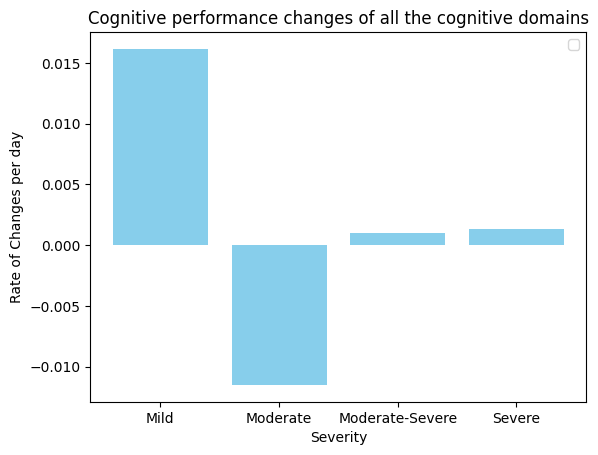

In [62]:
import matplotlib.pyplot as plt

# Plot data data, x axis is severity, y-axis is rate of change. one uni-domain of cognition for one plot line
# Using Numpy to create an array X

severity_levels = ['Mild', 'Moderate', 'Moderate-Severe', 'Severe']
xticklabels = [f"{sev}" for sev in severity_levels]

# Calculate the mean 'Rate of Change' for each severity level
changes = data.groupby('Severity')['Rate of Change'].mean()

# Reindex the changes Series to ensure the correct order of severity levels
changes = changes.reindex(severity_levels)

# Plotting the curve
plt.bar(changes.index, changes.values, color='skyblue')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Severity")
plt.ylabel("Rate of Changes per day")
plt.title("Cognitive performance changes of all the cognitive domains")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

In [63]:
# Create a dictionary to store dataframes for each unidomain cognitive column
unidomain_data = {}

# Iterate through cognitive domain columns
for col in cognitive_columns:
    # Filter for unidomain and the specific cognitive domain
    filtered_data = data[(data['Unidomain'] == 1) & (data[col] == 1)].copy()

    # Drop the 'Unidomain' and cognitive domain columns
    filtered_data.drop(columns=['Unidomain'] + cognitive_columns, inplace=True)

    # Store the filtered dataframe in the dictionary
    unidomain_data[col] = filtered_data

# You can access the dataframes using the cognitive domain names as keys
# For example, to access the dataframe for 'Cognitive domain: Perceptual-motor':
# perceptual_motor_data = unidomain_data['Cognitive domain: Perceptual-motor']

# To see the keys (cognitive domains) for which dataframes were created:
print("DataFrames created for the following cognitive domains:")
for key, df in unidomain_data.items():
    print(f"- {key}: {len(df)} rows")

DataFrames created for the following cognitive domains:
- Cognitive domain: Learning and Memory: 9 rows
- Cognitive domain: Language: 13 rows
- Cognitive domain: Perceptual-motor: 17 rows
- Cognitive domain: Complex attention: 5 rows
- Cognitive domain: Executive function: 7 rows
- Cognitive domain: Information processing speed, reaction time: 15 rows
- Cognitive domain: Social cognition: 0 rows


In [64]:
executive_function_data = unidomain_data['Cognitive domain: Executive function']
changes = executive_function_data.groupby('Severity')['Rate of Change'].mean()
executive_function_data['change'] = changes
print(executive_function_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 119 to 125
Data columns (total 44 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   Severity                                                                                               7 non-null      object 
 1   n                                                                                                      7 non-null      int64  
 2   Age, mean                                                                                              7 non-null      float64
 3   Age, standard deviation                                                                                7 non-null      float64
 4   Sex/gender, male/men (proportion)                                                                      

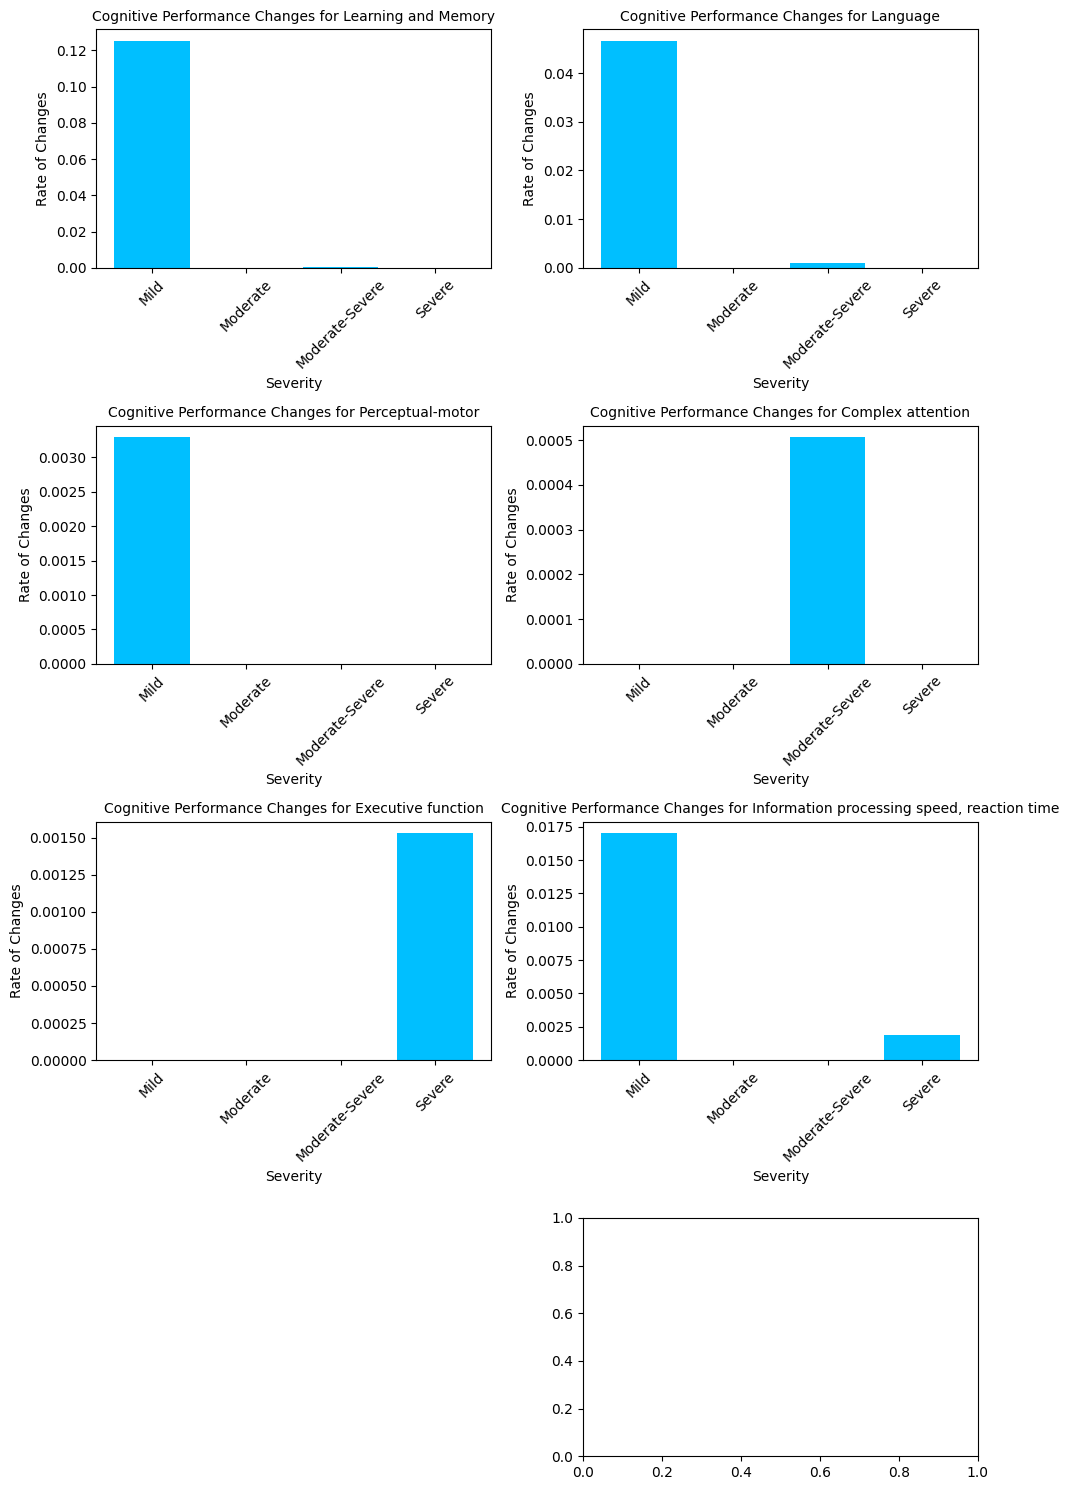

In [65]:
# Define severity levels
severity_levels = ['Mild', 'Moderate', 'Moderate-Severe', 'Severe']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through each cognitive domain and create a bar plot
for i, (domain, df) in enumerate(unidomain_data.items()):
    if not df.empty:
        # Calculate the mean 'Rate of Change' for each severity level
        changes = df.groupby('Severity')['Rate of Change'].mean()

        # Reindex to ensure all severity levels are present, filling missing with 0
        changes = changes.reindex(severity_levels, fill_value=0)

        # Plotting the bar chart
        axes[i].bar(changes.index, changes.values, color='deepskyblue')

        # Naming the axes and the subplot title
        axes[i].set_xlabel("Severity")
        axes[i].set_ylabel("Rate of Changes")
        axes[i].set_title(f"Cognitive Performance Changes for {domain.replace('Cognitive domain: ', '')}", fontsize=10)
        axes[i].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
    else:
        # Hide the subplot if no data is available for the domain
        fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

In [27]:
unidomain_counts = data[data['Unidomain'] == 1].groupby(cognitive_columns)['Unidomain'].count()
print(unidomain_counts)
# Find the cognitive column that has the largest counts
max_count = unidomain_counts.max()
max_count_indices = unidomain_counts[unidomain_counts == max_count].index
print(max_count_indices)
# Drop the data points if their domain is not unidomain, then drop the data point if the unidomain is not the max count domain
data1 = data[data['Unidomain'] == 1]
mask = data1[cognitive_columns].apply(tuple, axis=1).isin(max_count_indices) # 'Cognitive domain: Perceptual-motor',
data1 = data1[mask]
# print(data1.info())
data1.drop(columns=['Unidomain'], inplace=True)
data1.drop(columns=cognitive_columns, inplace=True)
print(data1.info())

Cognitive domain: Learning and Memory  Cognitive domain: Language  Cognitive domain: Perceptual-motor  Cognitive domain: Complex attention  Cognitive domain: Executive function  Cognitive domain: Information processing speed, reaction time  Cognitive domain: Social cognition
0                                      0                           0                                   0                                    0                                     1                                                              0                                     15
                                                                                                                                            1                                     0                                                              0                                      7
                                                                                                       1                                    0                   

In [ ]:
# Cognitive domain: 'Information processing speed, reaction time', 'Language', 'Learning and Memory', 'Executive function', 'Complex attention'
data2 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Language'] == True)] # Assuming 'Cognitive domain: Executive function' is a boolean column
# print(data1.info())
data2.drop(columns=['Unidomain'], inplace=True)
data2.drop(columns=cognitive_columns, inplace=True)
print(data2.info())

In [ ]:
data3 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Learning and Memory'] == True)]
data3.drop(columns=['Unidomain'], inplace=True)
data3.drop(columns=cognitive_columns, inplace=True)
print(data3.info())

data4 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Information processing speed, reaction time'] == True)]
data4.drop(columns=['Unidomain'], inplace=True)
data4.drop(columns=cognitive_columns, inplace=True)

data5 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Executive function'] == True)]
data5.drop(columns=['Unidomain'], inplace=True)
data5.drop(columns=cognitive_columns, inplace=True)

data6 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Executive function'] == True)]
data6.drop(columns=['Unidomain'], inplace=True)
data6.drop(columns=cognitive_columns, inplace=True)

data7 = data[(data['Unidomain'] == 1) & (data['Cognitive domain: Executive function'] == True)]
data7.drop(columns=['Unidomain'], inplace=True)
data7.drop(columns=cognitive_columns, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 210 to 218
Data columns (total 46 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   n                                                                                                      9 non-null      int64  
 1   Age, mean                                                                                              9 non-null      float64
 2   Age, standard deviation                                                                                9 non-null      float64
 3   Sex/gender, male/men (proportion)                                                                      8 non-null      float64
 4   Race, White (proportion)                                                                               

<ipython-input-40-e9f8c25f986c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(columns=['Unidomain'], inplace=True)
<ipython-input-40-e9f8c25f986c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(columns=cognitive_columns, inplace=True)


In [ ]:
# calculate training weights
combined_weight = data3['n'] / pow(2, data3['Age, standard deviation'])
simple_weight = data3['n']
data3.drop(columns=['n', 'Age, standard deviation','Education, <high school (proportion)',
       'Education, high school (proportion)',
       'Education, some college (proportion)',
       'Education, college (proportion)', 'Education, <12 years (proportion)',
       'Education, 12 years (proportion)', 'Education, >12 years (proportion)',
       'Education,  ≥ 12 years (proportion)'], inplace=True)
print(data3.info())
print(data3.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 210 to 218
Data columns (total 36 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   Age, mean                                                                                              9 non-null      float64
 1   Sex/gender, male/men (proportion)                                                                      8 non-null      float64
 2   Race, White (proportion)                                                                               0 non-null      float64
 3   Race, Black (proportion)                                                                               0 non-null      float64
 4   Race, Hispanic (proportion)                                                                            

<ipython-input-41-210ebd5cbbfb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(columns=['n', 'Age, standard deviation','Education, <high school (proportion)',


In [ ]:
X_e = data3.drop(columns=['Sex/gender, male/men (proportion)', 'Country of recruitment_Australia', 'Country of recruitment_Brazil',
       'Country of recruitment_Canada', 'Country of recruitment_China',
       'Country of recruitment_New Zealand', 'Country of recruitment_Norway',
       'Country of recruitment_South Korea',
       'Country of recruitment_UK (England)',
       'Country of recruitment_UK (Scotland)',
       'Country of recruitment_United States', 'Race, White (proportion)',
       'Race, Black (proportion)', 'Race, Hispanic (proportion)',
       'Race, Other (proportion)','Occupation, employed at time of injury (working for pay; full or part-time) (proportion)',
       'Occupation, not employed at time of injury (retired, in prison, student, housewife, etc) (proportion)',
       'Social capital, partnered (proportion)',
       'Social capital, unpartnered (proportion)', 'Mechanism of Injury, MVA',
       'Mechanism of Injury, falls', 'Mechanism of Injury, assault',
       'Mechanism of Injury, sport related',
       'Mechanism of Injury, work related/industrial',
       'Mechanism of Injury, domestic accident',
       'Mechanism of Injury, blast/explosive',
       'Mechanism of Injury, blunt/mechanical', 'Mechanism of Injury, other',])
Xs = data1.drop(columns=['Education, mean years',
       'Education, standard deviation ', 'Country of recruitment_Australia', 'Country of recruitment_Brazil',
       'Country of recruitment_Canada', 'Country of recruitment_China',
       'Country of recruitment_New Zealand', 'Country of recruitment_Norway',
       'Country of recruitment_South Korea',
       'Country of recruitment_UK (England)',
       'Country of recruitment_UK (Scotland)',
       'Country of recruitment_United States', 'Race, White (proportion)',
       'Race, Black (proportion)', 'Race, Hispanic (proportion)',
       'Race, Other (proportion)','Occupation, employed at time of injury (working for pay; full or part-time) (proportion)',
       'Occupation, not employed at time of injury (retired, in prison, student, housewife, etc) (proportion)',
       'Social capital, partnered (proportion)',
       'Social capital, unpartnered (proportion)', 'Mechanism of Injury, MVA',
       'Mechanism of Injury, falls', 'Mechanism of Injury, assault',
       'Mechanism of Injury, sport related',
       'Mechanism of Injury, work related/industrial',
       'Mechanism of Injury, domestic accident',
       'Mechanism of Injury, blast/explosive',
       'Mechanism of Injury, blunt/mechanical', 'Mechanism of Injury, other',])
# X_r = data4.drop(columns=['Education, mean years','Education, standard deviation ', 'Sex/gender, male/men (proportion),' 'Output'])
X = X_e.drop(columns=['Education, mean years', 'Education, standard deviation '])
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 210 to 218
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age, mean                 9 non-null      float64
 1   Rate of Change            9 non-null      float64
 2   Severity_Mild             9 non-null      bool   
 3   Severity_Moderate         9 non-null      bool   
 4   Severity_Moderate-Severe  9 non-null      bool   
 5   Severity_Severe           9 non-null      bool   
dtypes: bool(4), float64(2)
memory usage: 252.0 bytes
None


In [ ]:
# PCA test
# pcadata = X

# # Convert all columns to numeric, coercing errors to NaN
# for col in pcadata.columns:
#     pcadata[col] = pd.to_numeric(pcadata[col], errors='coerce')

# # Drop rows with NaN values
# pcadata = pcadata.dropna()

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pcadata)
# #Check whether X_scaled is centered
# print(X_scaled.mean(axis=0))
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pcadata)
# #Check whether X_scaled is centered
# print(X_scaled.mean(axis=0))

[ 3.46128355e-16  2.61228947e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.30614473e-17]
[ 3.46128355e-16  2.61228947e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.30614473e-17]


[0.58671731 0.86978857 1.         1.         1.         1.
 1.        ]
Number of components to retain 95% variance: 3


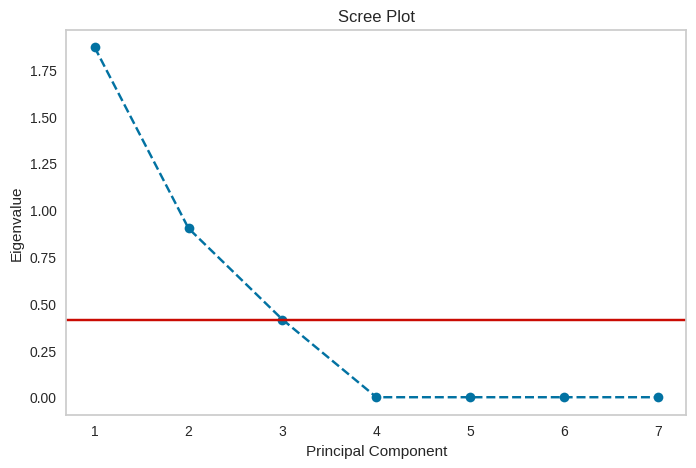

In [ ]:
# Perform PCA
# pca = PCA()
# pca.fit(X_scaled)

# # Cumulative variance
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# print(cumulative_variance)

# # Select components retaining 95% variance
# n_components = np.argmax(cumulative_variance >= 0.95) + 1
# print(f"Number of components to retain 95% variance: {n_components}") # 6

# # # Get eigenvalues (explained variance)
# eigenvalues = pca.explained_variance_

# # Scree plot
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
# plt.axhline(y=eigenvalues[n_components - 1], color='r', linestyle='-', label=f'Threshold at PC {n_components}')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Eigenvalue')
# plt.xticks(range(1, len(eigenvalues) + 1))
# plt.grid()
# plt.show()

In [ ]:
# Apply the number of component
# pca_screed = PCA(n_components=3)
# pca_screed.fit(X_scaled)
# x = pca_screed.transform(X_scaled)
# print(pca_screed.components_)

[[ 0.6319785   0.65532235 -0.         -0.         -0.         -0.
   0.4137098 ]
 [-0.36883472 -0.21516279 -0.          0.          0.          0.
   0.90424882]
 [-0.68158941  0.72405635 -0.         -0.         -0.         -0.
  -0.10572738]]


In [ ]:
# Apply Weighted K-Means
# First check the data type
def bestK(X):
  n_samples = X.shape[0]
  print(X)

  # Use Sihouette method to check the optimal value for k
  ds = X
  k_values = range(2, min(n_samples, 10))
  silhouette_scores = []

  best_k = None
  best_silhouette_score = -1

  # Iterate through different K values
  for k in k_values:
      km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
      km.fit(ds)

      # Calculate the average silhouette score
      silhouette_avg = silhouette_score(ds, km.labels_)
      silhouette_scores.append(silhouette_avg)

      # Update the best K value if a higher silhouette score is found
      if silhouette_avg > best_silhouette_score:
          best_k = k
          best_silhouette_score = silhouette_avg

  # Output the best K value and corresponding Silhouette Score
  print("Best K value:", best_k)
  print("Best Silhouette Score:", best_silhouette_score)
  # Create a plot to visualize Silhouette Scores
  plt.plot(k_values, silhouette_scores)
  plt.xlabel("Number of Clusters (K)")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Score vs. Number of Clusters")
  plt.show()

  return best_k

In [ ]:
def clustering(X, k, weight, initMethod):
    # Apply Weighted K-Means
  kmeans = KMeans(n_clusters=k, random_state=42, init=initMethod)
  y_KM_K3 = kmeans.fit_predict(X, sample_weight=weight)
  X_k3 = X.copy()
  X_k3['cluster'] = y_KM_K3
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_

  # Cluster assignments and centroids
  print("Cluster labels:", labels)
  print("Centroids:", centroids)

  return y_KM_K3, centroids

In [ ]:
# Evaluate
def clusterEva(X, y):
  silhouette = silhouette_score(X, y)
  print("Silhouette Score:", silhouette)

In [ ]:
# Visual Inspection
def clusterVis(X, y, centroids, k):
  if k ==3:
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],c="black",s=80,label="Centers",alpha=1)
    ax.scatter(X.iloc[y == 0,0],X.iloc[y == 0,1],X.iloc[y == 0,2], s = 40 , color = 'blue', label = "cluster 0")
    ax.scatter(X.iloc[y == 1,0],X.iloc[y == 1,1],X.iloc[y == 1,2], s = 40 , color = 'orange', label = "cluster 1")
    ax.scatter(X.iloc[y == 2,0],X.iloc[y == 2,1],X.iloc[y == 2,2], s = 40 , color = 'green', label = "cluster 2")
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_zlabel(X.columns[2])
    ax.legend()
    plt.title('Cluster Visualization')
    plt.show()
  elif k == 2:
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, cmap='viridis')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title('Cluster Visualization')
    plt.show()
  else:
    return

     Age, mean   Rate of Change  Severity_Mild  Severity_Moderate  \
210       28.70       -0.001389          False              False   
211       28.70        0.001597          False              False   
212       28.70        0.000741          False              False   
213       28.70        0.001170          False              False   
214       28.70        0.000000          False              False   
215       28.70        0.000794          False              False   
216       28.70        0.000654          False              False   
217       28.70        0.000261          False              False   
218       20.04        0.125282           True              False   

     Severity_Moderate-Severe  Severity_Severe  
210                      True            False  
211                      True            False  
212                      True            False  
213                      True            False  
214                      True            False  
215            

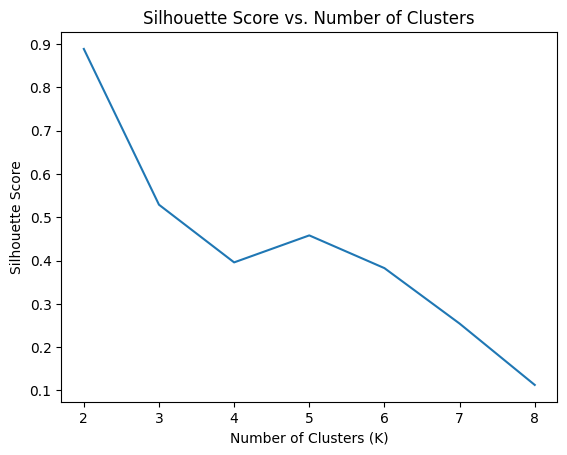

Cluster labels: [1 1 1 1 1 1 1 1 0]
Centroids: [[2.00400000e+01 1.25281884e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.87000000e+01 4.78418524e-04 1.38777878e-17 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]
Silhouette Score: 0.8887860261234958
[1 1 1 1 1 1 1 1 0]


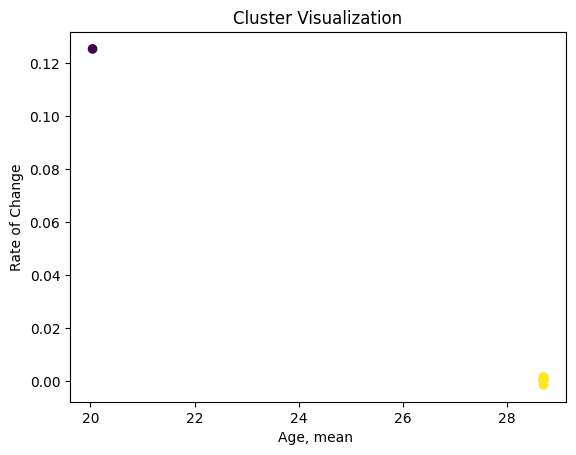

In [ ]:
def train(X, weight, initMethod):
  k = bestK(X)
  [y, centroids] = clustering(X, k, weight, initMethod)
  clusterEva(X, y)

  return y, centroids, k

# Basic model weight with SD of age2 included
[y, centroids, k] = train(X, combined_weight, 'k-means++')
print(y)
clusterVis(X, y, centroids, k)

# Basic model weight with SD of age2 included
# [y1, centroids1, k1] = train(X, simple_weight)
# print(y1)
# clusterVis(X, y1, centroids1, k1)

     Age, mean   Education, mean years  Education, standard deviation   \
174       43.68                  14.32                            2.72   
175       43.68                  14.32                            2.72   
176       43.68                  14.32                            2.72   
177       43.68                  14.32                            2.72   
178       43.68                  14.32                            2.72   
179       43.68                  14.32                            2.72   
180       43.68                  14.32                            2.72   
181       43.68                  14.32                            2.72   
182       33.40                  14.30                            2.50   
183       33.40                  14.30                            2.50   
184       33.40                  14.30                            2.50   
185       33.40                  14.30                            2.50   
186       33.40                  14.30

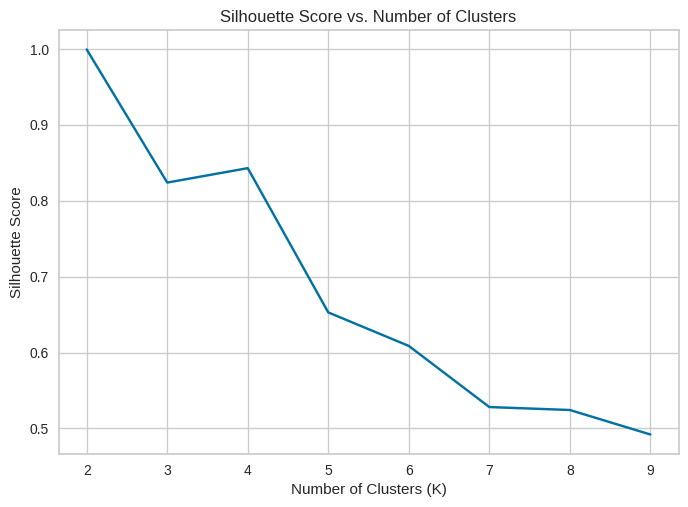

Cluster labels: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Centroids: [[ 3.34000000e+01  1.43000000e+01  2.50000000e+00 -4.79431907e-04
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.36800000e+01  1.43200000e+01  2.72000000e+00  7.53942433e-03
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Silhouette Score: 0.9993884741182375


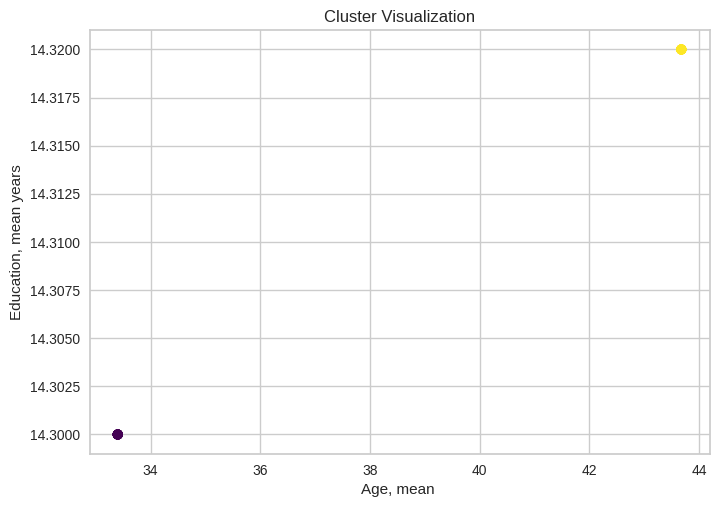

In [ ]:
[y_e, centroids_e, k_e] = train(X_e)
clusterVis(X_e, y_e, centroids_e, k_e)

     Age, mean   Sex/gender, male/men (proportion)  Rate of Change  \
174       43.68                              0.732        0.008995   
175       43.68                              0.732        0.016738   
176       43.68                              0.732        0.008195   
177       43.68                              0.732        0.006357   
178       43.68                              0.732        0.018436   
179       43.68                              0.732        0.004567   
180       43.68                              0.732        0.000535   
181       43.68                              0.732       -0.003508   
182       33.40                              0.726       -0.000697   
183       33.40                              0.726       -0.003044   
184       33.40                              0.726        0.005102   
185       33.40                              0.726       -0.000847   
186       33.40                              0.726        0.003189   
187       33.40     

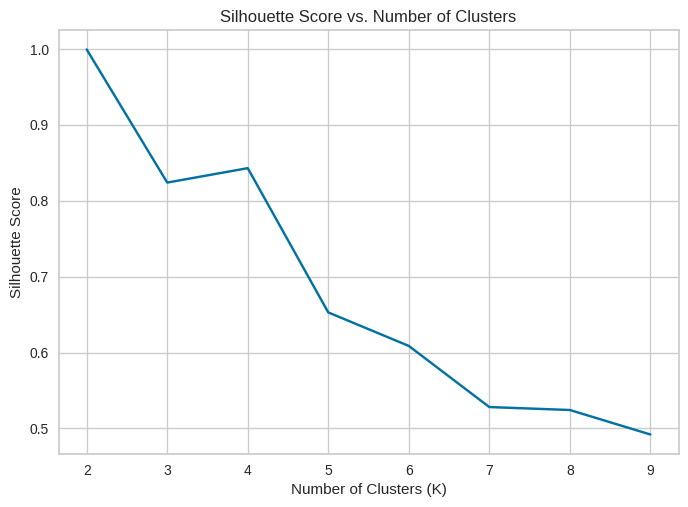

Cluster labels: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Centroids: [[ 3.34000000e+01  7.26000000e-01 -4.79431907e-04  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.36800000e+01  7.32000000e-01  7.53942433e-03  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Silhouette Score: 0.9993883330447202
     Age, mean   Sex/gender, male/men (proportion)  Rate of Change  \
174       43.68                              0.732        0.008995   
175       43.68                              0.732        0.016738   
176       43.68                              0.732        0.008195   
177       43.68                              0.732        0.006357   
178       43.68                              0.732        0.018436   
179       43.68                              0.732        0.004567   
180       43.68                              0.732        0.000535   
181       43.68                              0.732       -0.003508   
182       33.40                    

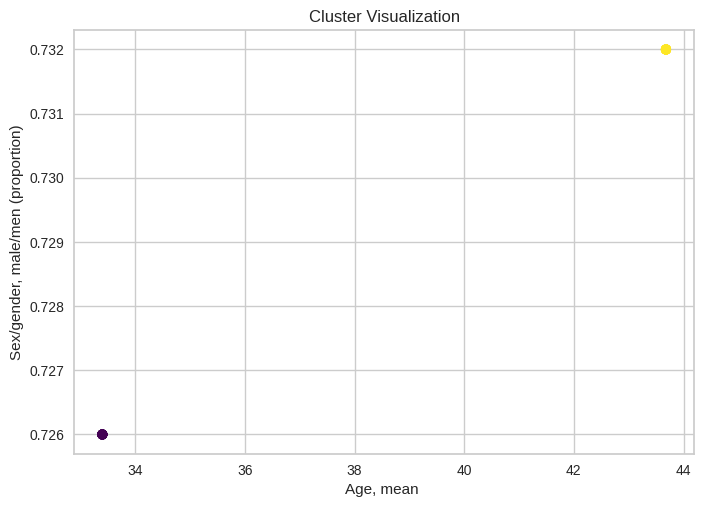

In [ ]:
[ys, centroidss, ks] = train(Xs)
print(Xs)
clusterVis(Xs, ys, centroidss, ks)

In [ ]:
# # 3d scatterplot using plotly
# Scene = dict(xaxis = dict(title  = 'Age of participants-->'),yaxis = dict(title  = 'Rate of Assessment Change-->'),zaxis = dict(title  = 'Severity of Ingury-->'))

# trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
# layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
# data = [trace]
# fig = go.Figure(data = data, layout = layout)
# fig.show()

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
X_e = data4.drop(columns=['Sex/gender, male/men (proportion)', 'Country of recruitment_Australia', 'Country of recruitment_Brazil',
       'Country of recruitment_Canada', 'Country of recruitment_China',
       'Country of recruitment_New Zealand', 'Country of recruitment_Norway',
       'Country of recruitment_South Korea',
       'Country of recruitment_UK (England)',
       'Country of recruitment_UK (Scotland)',
       'Country of recruitment_United States', 'Output'])
X_s = data4.drop(columns=['Education, mean years',
       'Education, standard deviation ', 'Country of recruitment_Australia', 'Country of recruitment_Brazil',
       'Country of recruitment_Canada', 'Country of recruitment_China',
       'Country of recruitment_New Zealand', 'Country of recruitment_Norway',
       'Country of recruitment_South Korea',
       'Country of recruitment_UK (England)',
       'Country of recruitment_UK (Scotland)',
       'Country of recruitment_United States', 'Output'])
# X_r = data4.drop(columns=['Education, mean years','Education, standard deviation ', 'Sex/gender, male/men (proportion),' 'Output'])
X = X_e.drop(columns=['Education, mean years', 'Education, standard deviation '])

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=52)
# X_e_train, X_e_test, Y_e_train, Y_e_test = train_test_split(X_e, Y, test_size=0.2, random_state=52)
# X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y, test_size=0.2, random_state=52)
# # X_r_train, X_r_test, Y_r_train, Y_r_test = train_test_split(X_r, Y, test_size=0.2, random_state=52)
# w_train, w_test = train_test_split(combined_weight, test_size=0.2, random_state=52)

In [ ]:
# scaler1 = StandardScaler()
# # Reshape combined_weight to 2D
# combined_weight_reshaped = w_train.values.reshape(-1, 1)
# # Apply StandardScaler
# weight_2D = scaler1.fit_transform(combined_weight_reshaped)
# weight = weight_2D.reshape(-1)

# # scaler2 = StandardScaler()
# # scaler2.fit(X)
# # X_train = scaler2.transform(X_train)
# # X_test = scaler2.transform(X_test)

#  # 1st try on education
# scaler3 = StandardScaler()
# scaler3.fit(X_e)
# X_e_train = scaler3.transform(X_e_train)
# X_e_test = scaler3.transform(X_e_test)

# # Apply PCA on train and test data
# pca1 = PCA(n_components=2) # set the n_component less than the #X_test
# pca1.fit(X_train) # fit on the training set only
# X_train = pca1.transform(X_train)
# X_test = pca1.transform(X_test)

# pca2 = PCA(n_components=2)
# pca2.fit(X_e_train)
# X_e_train = pca2.transform(X_e_train)
# X_e_test = pca2.transform(X_e_test)

ValueError: could not convert string to float: 'Steady'

In [ ]:
# Check data type
# print(X['LastFUTime(days)'])
#  Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, Y_train, sample_weight=w_train)
Y_pred = rfc.predict(X_test)

# rfc+edu
rfcedu = RandomForestClassifier(random_state=42)
rfcedu.fit(X_e_train, Y_e_train, sample_weight=w_train)
Y_e_pred = rfcedu.predict(X_e_test)

ValueError: could not convert string to float: '1`'

In [ ]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f'Accuracy: {accuracy}')
print("Classication Report")
print(class_report)
print("Confusion Matrix")
print(conf_matrix)

# AUC-ROC (for binary classification)
Y_pred_proba = rfc.predict_proba(X_test)[:, 1]  # Probability for the positive class
print("AUC-ROC:", roc_auc_score(Y_test, Y_pred_proba))

# # Examine and visualize feature importance, test overfitting
# feature_importances = model.feature_importances_
# feature_names = data_train.drop(columns=['Assessment Outcome (BL to last FU)'], inplace=True).columns
# # print(feature_names.tolist())
# importance_df = pd.DataFrame({'feature': feature_names, 'importance':feature_importances})
# # Round the 'importance' column to 4 decimal places
# importance_df['importance'] = importance_df['importance'].round(4)
# importance_df = importance_df.set_index('feature')
# # Reshape DataFrame for heatmap

# # print(importance_df.index.tolist())
# # print(importance_df.index.tolist()) # Same as X_train.columns
# # Assign group flages to primary predictors(y1), effect modifiers(y2), and cognitive domain&measurements(x)
# for feature in importance_df.index:
#     if feature in ['Sex/gender, male/men (proportion)', 'Sex/gender, male/men (proportion)', \
#                 'Race, White (proportion)', 'Race, Black (proportion)', 'Race, Hispanic (proportion)', \
#                 'Race, Other (proportion)', 'Race, Unknown (proportion)', \
#                 'Sex/gender, male/men (proportion)_missing', 'Race, White (proportion)_missing', \
#                 'Race, Black (proportion)_missing', 'Race, Hispanic (proportion)_missing', \
#                 'Race, Other (proportion)_missing', 'Race, Unknown (proportion)_missing']:
#         importance_df.at[feature, 'flag'] = 'Primary Predictors' # Avoid overwrting
#     elif feature in ['Baseline (months)', 'BL to last FU (months)','age_norm','mod-sev', 'sev']:
#         importance_df.at[feature, 'flag'] = 'Effect Modifiers'
#     else:
#         importance_df.at[feature, 'flag'] = 'Coganative Domains & Measurements'
# # print(importance_df.columns) # ['importance', 'flag']

# importance_df = importance_df.sort_values(by=['flag', 'importance'], ascending=[True, True])
# # print(importance_df)

# # importance_df = importance_df.groupby('flag')

# # for key, values in importance_df:
# #     print(importance_df.get_group(key), "\n\n")

# heatmap_df = importance_df.drop(columns='flag')

# # Interactive heatmap
# fig = ff.create_annotated_heatmap(z=heatmap_df.values,
#                                    x=heatmap_df.columns.tolist(),
#                                    y=heatmap_df.index.tolist(),
#                                    colorscale='YlGnBu')
# # PP for primary predictor, EM for effect modifiers, CDM for cognitive domain&measures
# fig.update_layout(title='Feature Importance Heatmap', xaxis_title='Importance', yaxis_title='Features: PP & EM & CDM')
# fig.show()

Accuracy: 1.0
Classication Report
              precision    recall  f1-score   support

      Steady       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Confusion Matrix
[[4]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# Create subplots for each unidomain cognitive domain
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through each cognitive domain and create a scatter plot
for i, (domain, df) in enumerate(unidomain_data.items()):
    if not df.empty and 'Education, mean years' in df.columns and 'Rate of Change' in df.columns:
        # Create a scatter plot
        sns.regplot(x='Education, mean years', y='Rate of Change', data=df, ax=axes[i])

        # Naming the axes and the subplot title
        axes[i].set_xlabel("Education (mean years)")
        axes[i].set_ylabel("Rate of Changes")
        axes[i].set_title(f"Education vs. Rate of Change for {domain.replace('Cognitive domain: ', '')}")
    else:
        # Hide the subplot if no data or required columns are available
        fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()